In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import re

# Cleaning Functions

In [3]:
def clean_line_text(df):
    import re
    badChars = re.compile('[^A-Z \-?\.&\'\[\],*!\%]', re.I)
    df['line_text'] = df['line_text'].map(lambda x: badChars.sub('', x))
    return df

def clean_speaker_names(df):
    df['speaker'] = df['speaker'].str.strip().str.lower()
    return df

def drop_deleted_scenes(df):
    df = df[df['deleted'] == False]
    del df['deleted']
    return df.reset_index(drop=True)


In [4]:
def do_all_data_loading():
    df = pd.read_csv('data/the-office-lines-scripts.csv')
    df = clean_line_text(df)
    df = clean_speaker_names(df)
    df = drop_deleted_scenes(df)
    return df

### First Look at Data

In [5]:
df = do_all_data_loading()

In [6]:
df[df['line_text'].str.contains('Bears.  Beets.  Battlestar')]

,id,season,episode,scene,line_text,speaker
13409,15346,3,20,1,Fact. Bears eat beets. Bears. Beets. Battl...,jim


##  EDA Functions

In [7]:
def line_search(line, speaker=None):
    if speaker:
        speaker = df['speaker'] == speaker
    else:
        speaker = True

    line = line.replace(' ', '\s*')
    line = df['line_text'].str.contains(line, regex=True, flags=re.I)

    return df[line & speaker]

In [8]:
line_search('bears. beets. battlestar')

,id,season,episode,scene,line_text,speaker
13409,15346,3,20,1,Fact. Bears eat beets. Bears. Beets. Battl...,jim


In [9]:
def get_dialogue(season, episode, scenes=None):
    season = df['season'] == season
    episode = df['episode'] == episode

    if scenes:
        if type(scenes) != list:
            scenes = [scenes]
        else:
            scenes = list(range(*scenes))

        scenes = df['scene'].isin(scenes)
    else:
        scenes = True

    return df[season & episode & scenes]

In [10]:
get_dialogue(season=3, episode=20, scenes=[1, 3])

,id,season,episode,scene,line_text,speaker
13405,15342,3,20,1,[Dressed as Dwight] It's kind of blurry. [puts...,jim
13406,15343,3,20,1,That's a ridiculous question.,dwight
13407,15344,3,20,1,False. Black bear.,jim
13408,15345,3,20,1,Well that's debatable. There are basically tw...,dwight
13409,15346,3,20,1,Fact. Bears eat beets. Bears. Beets. Battl...,jim
13410,15347,3,20,1,Bears do not--- What is going on--- What are y...,dwight
13411,15348,3,20,2,"Last week, I was in a drug store and I saw the...",jim


## Actually Doing EDA

## The Cast

#### Who's considered to be core cast?

There are a lot of characters with lines in the show

In [11]:
len(df['speaker'].unique())

771

This looks good

In [12]:
print(df['speaker'].value_counts()[:26])

michael     11578
dwight       7169
jim          6612
pam          5206
andy         3968
kevin        1668
angela       1658
erin         1469
oscar        1444
ryan         1301
darryl       1228
phyllis      1031
kelly         935
jan           898
toby          889
stanley       732
meredith      631
holly         608
nellie        529
gabe          436
creed         431
robert        430
david         382
karen         340
clark         260
deangelo      250
Name: speaker, dtype: int64


In [13]:
def filter_cast(df, minLines=100):
    lineCounts = df['speaker'].value_counts()
    importantPeople = lineCounts[lineCounts > minLines].index

    filtered = df[df['speaker'].isin(importantPeople)]

    return filtered.reset_index(drop=True)

In [14]:
filteredCast = filter_cast(df, 250)
filteredCast['speaker'].unique()

array(['michael', 'jim', 'pam', 'dwight', 'jan', 'phyllis', 'stanley',
       'oscar', 'angela', 'kevin', 'ryan', 'toby', 'kelly', 'meredith',
       'darryl', 'creed', 'david', 'andy', 'karen', 'holly', 'erin',
       'gabe', 'clark', 'robert', 'nellie'], dtype=object)

#### Who shares the screen the most?

First we need to get a neat record of who's in each scene.

In [15]:
def get_cast_by_scene(df):
    gb = df.groupby(['season', 'episode', 'scene'])

    # Each record will be a list of every present character
    s = gb['speaker'].unique().reset_index(drop=True)

    # Each record is at the present (scene, character) level
    tallCastByScene = s.apply(pd.Series).stack()

    # Consolidate each scene to one row
    castByScene = pd.get_dummies(tallCastByScene).sum(level=0)

    return castByScene

In [16]:
castByScene = get_cast_by_scene(filteredCast)
castByScene.head()

,andy,angela,clark,creed,darryl,david,dwight,erin,gabe,holly,...,meredith,michael,nellie,oscar,pam,phyllis,robert,ryan,stanley,toby
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


If we take every record where `andy` is in a scene, then sum every other column, we get the number of times they have lines together in a scene.

In [17]:
castByScene[castByScene['andy'] > 0].sum()

andy        1341
angela       142
clark         21
creed         57
darryl       138
david          9
dwight       332
erin         230
gabe          37
holly          9
jan            9
jim          317
karen         20
kelly         84
kevin        203
meredith      95
michael      225
nellie        35
oscar        167
pam          220
phyllis      179
robert        57
ryan          74
stanley      131
toby          39
dtype: int64

Repeat this for every pair in our DataFrame

In [18]:
pairs = {char:None for char in castByScene}

for char in castByScene:
    pairs[char] = castByScene[castByScene[char] > 0].sum()

To get a matrix of shared-scene counts

In [19]:
pairValues = pd.DataFrame(pairs).values
pairValues

array([[1341,  142,   21,   57,  138,    9,  332,  230,   37,    9,    9,
         317,   20,   84,  203,   95,  225,   35,  167,  220,  179,   57,
          74,  131,   39],
       [ 142,  738,    8,   46,   34,    0,  280,   61,   14,    9,   16,
         133,   15,   83,  210,   86,  178,   26,  199,  186,  146,   11,
          33,   76,   42],
       [  21,    8,   92,    3,   12,    0,   47,   13,    0,    0,    1,
          15,    0,    0,   12,    9,    0,    5,   11,   16,   10,    0,
           0,   11,    3],
       [  57,   46,    3,  293,   16,    2,   81,   28,   10,    3,    3,
          83,    3,   31,   63,   44,   79,   13,   57,   74,   57,    5,
          29,   43,   26],
       [ 138,   34,   12,   16,  470,    0,   95,   39,   29,   20,    1,
          91,    2,   32,   89,   34,  110,   21,   67,   77,   62,    7,
          23,   32,   32],
       [   9,    0,    0,    2,    0,   86,   19,    4,    0,    2,    8,
          21,    2,    3,    2,    3,   58,    1,  

However, this data is mirrored on the diag (Jim/Dwight is the same as Dwight/Jim)

In [20]:
import numpy as np
np.all(np.transpose(pairValues) == pairValues)

True

So for neatness, we're going to throw away the redundant data.

In [21]:
np.tril(pairValues, k=-1)

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [142,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 21,   8,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 57,  46,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [138,  34,  12,  16,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  9,   0,   0,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [332, 280,  47,  81,  95,  19,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
      

Giving us

In [22]:
def shared_scene_matrix(castByScene):
    '''
    Pairwise number of shared scenes by character,
    trimmed to a lower-triangular matrix
    '''
    pairs = {char:None for char in castByScene}

    for char in castByScene:
        pairs[char] = castByScene[castByScene[char] > 0].sum()
        
    pairValues = pd.DataFrame(pairs)
    return np.tril(pairValues, k=-1)

## And then we can plot it with

In [23]:
def pairwise_scene_plot(scenePairs):
    fig, ax = plt.subplots(figsize=(18, 10))

    scenePairs = shared_scene_matrix(castByScene)

    im = ax.imshow(scenePairs, cmap='jet')
    ax.figure.colorbar(im)

    _ = ax.set_xticks(np.arange(len(pairs)))
    _ = ax.set_yticks(np.arange(len(pairs)))

    _ = ax.set_xticklabels(pairs, rotation=45, ha='right')
    _ = ax.set_yticklabels(pairs)

    _ = ax.set_title('Number of Scenes Shared, by Character', size=20)

    return ax

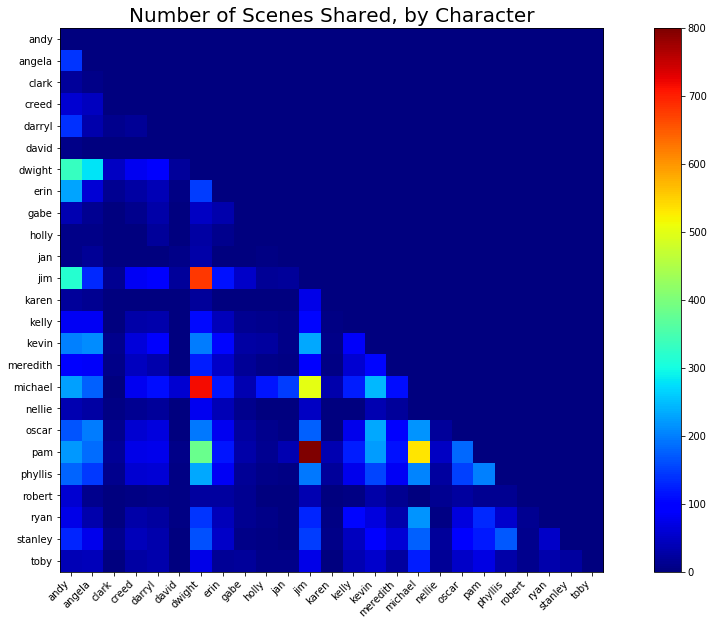

In [24]:
fig, ax = plt.subplots(figsize=(18, 10))

scenePairs = shared_scene_matrix(castByScene)

im = ax.imshow(scenePairs, cmap='jet')
ax.figure.colorbar(im)

_ = ax.set_xticks(np.arange(len(pairs)))
_ = ax.set_yticks(np.arange(len(pairs)))

_ = ax.set_xticklabels(pairs, rotation=45, ha='right')
_ = ax.set_yticklabels(pairs)

_ = ax.set_title('Number of Scenes Shared, by Character', size=20)

#  The Text

### Who Swears the most?

In [25]:
line_search('\*')['speaker'].value_counts()

kevin       2
michael     2
deangelo    1
kelly       1
phyllis     1
brandon     1
jo          1
pam         1
andy        1
ryan        1
robert      1
darryl      1
toby        1
oscar       1
Name: speaker, dtype: int64

## Who sets Michael up the most?

In [26]:
df.loc[line_search('what she said').index - 1]['speaker'].value_counts()

michael         11
jim              5
lester           4
dwight           2
jan              2
darryl           1
gabe             1
holly            1
andy             1
pam              1
david            1
clark            1
doctor           1
second cindy     1
kelly            1
phyllis          1
kevin            1
angela           1
Name: speaker, dtype: int64

Who's Lester?

In [27]:
setups = df.loc[line_search('what she said').index - 1]
setups[setups['speaker'] == 'lester']

,id,season,episode,scene,line_text,speaker
18332,20269,4,8,23,And you were directly under her the entire time?,lester
18334,20271,4,8,23,Excuse me?,lester
18340,20277,4,8,23,"With all due respect, I'm in the middle of a l...",lester
18345,20282,4,8,23,Can you go back to where this digression began?,lester


In [28]:
get_dialogue(4, 8, 23)

,id,season,episode,scene,line_text,speaker
18328,20265,4,8,23,How long have you known the plaintiff?,lester
18329,20266,4,8,23,I haven't actually seen it. But I have seen th...,michael
18330,20267,4,8,23,How long have you known Ms. Levinson?,lester
18331,20268,4,8,23,Six years and two months.,michael
18332,20269,4,8,23,And you were directly under her the entire time?,lester
18333,20270,4,8,23,That's what she said.,michael
18334,20271,4,8,23,Excuse me?,lester
18335,20272,4,8,23,That's what she said.,michael
18336,20273,4,8,23,Ms. Levinson told you she was your direct supe...,lester
18337,20274,4,8,23,"Uh, wh-why would she say that?",michael


### Michael and Toby

Michael hates Toby. It'd be interesting to zero in on words he uses after Toby speaks.

In [29]:
mnt = df[df['speaker'].isin(['michael', 'toby'])]
sample = mnt.iloc[3510:3520]

We expect each of Michael's lines in scene 19 to evaluate to True

In [30]:
sample

,id,season,episode,scene,line_text,speaker
10977,12879,3,11,15,I have a special assignment for you.,michael
10979,12881,3,11,15,A sensitive email has been released to the off...,michael
10981,12883,3,11,15,Not important.,michael
10983,12885,3,11,15,"OK, forget it.",michael
10995,12897,3,11,19,Hey I need to talk to you right now.,toby
10996,12898,3,11,19,"Not now, not ever.",michael
10997,12899,3,11,19,About you and Jan.,toby
10998,12900,3,11,19,"Aww, none of your business.",michael
10999,12901,3,11,19,"Wish it were true, but it, it uh, seems from t...",toby
11000,12902,3,11,19,That photo is my personal property and if you ...,michael


In [31]:
sample['speaker'].shift(1)

10977        NaN
10979    michael
10981    michael
10983    michael
10995    michael
10996       toby
10997    michael
10998       toby
10999    michael
11000       toby
Name: speaker, dtype: object

In [32]:
def _within_two_lines(col, personA, personB):
    ''' Within 2 lines '''

    a = col == personA
    b = col.shift(1) == personB
    c = col.shift(2) == personB

    return a & (b | c)

sample.groupby(['season', 'episode'])['speaker'].transform(lambda x: _within_two_lines(x, 'michael', 'toby'))

10977    False
10979    False
10981    False
10983    False
10995    False
10996     True
10997    False
10998     True
10999    False
11000     True
Name: speaker, dtype: bool

In [33]:
def _within_two_scenes(col):
    return (col - col.shift(2)) < 2

sample.groupby(['season', 'episode'])['scene'].transform(_within_two_scenes)

10977    False
10979    False
10981     True
10983     True
10995    False
10996    False
10997     True
10998     True
10999     True
11000     True
Name: scene, dtype: bool

In [34]:
def a_spoke_after_b(df, personA, personB):
    sameScene = (df.groupby(['season', 'episode'])['scene']
                   .transform(_within_two_scenes))
    aAfterB = (df.groupby(['season', 'episode'])['speaker']
                 .transform(lambda x: _within_two_lines(x, personA, personB)))

    return (sameScene & aAfterB)

In [35]:
a_spoke_after_b(sample, 'michael', 'toby')

10977    False
10979    False
10981    False
10983    False
10995    False
10996    False
10997    False
10998     True
10999    False
11000     True
dtype: bool

#### And some NLTK utilities to ease the cleaning

In [36]:
def _clean_word(word):
    return ''.join(re.findall('[a-z\s]', word.lower().strip()))

In [37]:
from nltk.corpus import stopwords

stopWords = [_clean_word(x) for x in stopwords.words('english')]

In [38]:
def extract_corpus(df):
    joinedText = ' '.join(df['line_text'].values)
    
    eachWord = joinedText.split()
    eachWord = [_clean_word(x) for x in eachWord]
    
    stopWords = [_clean_word(x) for x in stopwords.words('english')]
    
    return [word for word in eachWord
            if word not in stopWords]

In [39]:
michaelCorpus = extract_corpus(sample[a_spoke_after_b(sample, 'michael', 'toby')])
print(michaelCorpus)

['aww', 'none', 'business', 'photo', 'personal', 'property', 'telling', 'went', 'computer', 'stole', 'photo', 'going', 'call', 'cops']
